In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import fastai
from fastai.vision import *
from fastai.callbacks import *
from fastai.vision.gan import *

In [3]:
path = Path("/home/ricky/Desktop/repos/fastai_course/data/oxford-iiit-pet/")
path_hr = path/"images"
path_lr = path/"crappy"

## Crappified data 

In [4]:
from crappify import *

In [5]:
il = ImageList.from_folder(path_hr)
parallel(crappifier(path_lr, path_hr), il.items)

In [6]:
bs, size = 16, 128
arch = models.resnet34

## Pre-train generator 

In [7]:
arch = models.resnet34
src = ImageImageList.from_folder(path_lr).split_by_rand_pct(0.1, seed=42)

In [8]:
def get_data(bs, size):
    data = (src.label_from_func(lambda x: path_hr/x.name)
           .transform(get_transforms(max_zoom=2.), size=size, tfm_y=True)
           .databunch(bs=bs).normalize(imagenet_stats, do_y=True))
    data.c = 3
    return data

In [9]:
data_gen = get_data(bs, size)

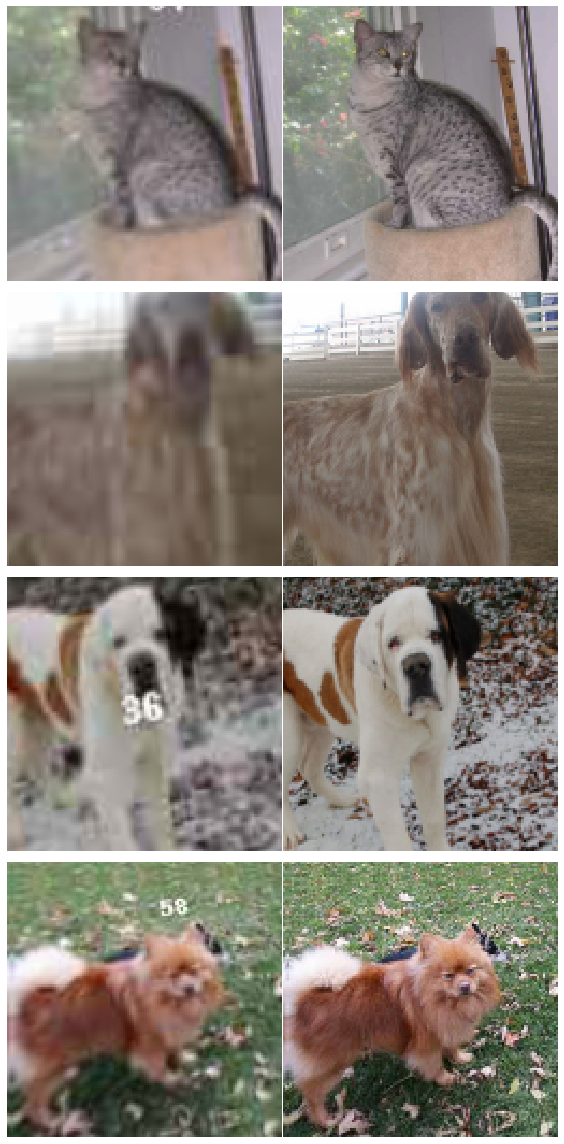

In [10]:
data_gen.show_batch(4)

In [11]:
wd = 1e-3

In [12]:
y_range = (-3, 3.)

In [13]:
loss_gen = MSELossFlat()

In [14]:
def create_gen_learner():
    return unet_learner(data_gen, arch, wd=wd, blur=True, norm_type=NormType.Weight,
                       self_attention=True, y_range=y_range, loss_func=loss_gen)

In [15]:
learn_gen = create_gen_learner()

In [28]:
learn_gen.fit_one_cycle(2, pct_start=0.8)

epoch,train_loss,valid_loss,time
0,0.067275,0.055128,01:44
1,0.051450,0.048304,01:39


In [29]:
learn_gen.unfreeze()

In [30]:
learn_gen.fit_one_cycle(3, slice(1e-6, 1e-3))

epoch,train_loss,valid_loss,time
0,0.050519,0.047534,01:46
1,0.048729,0.046015,01:47
2,0.048394,0.045308,01:47


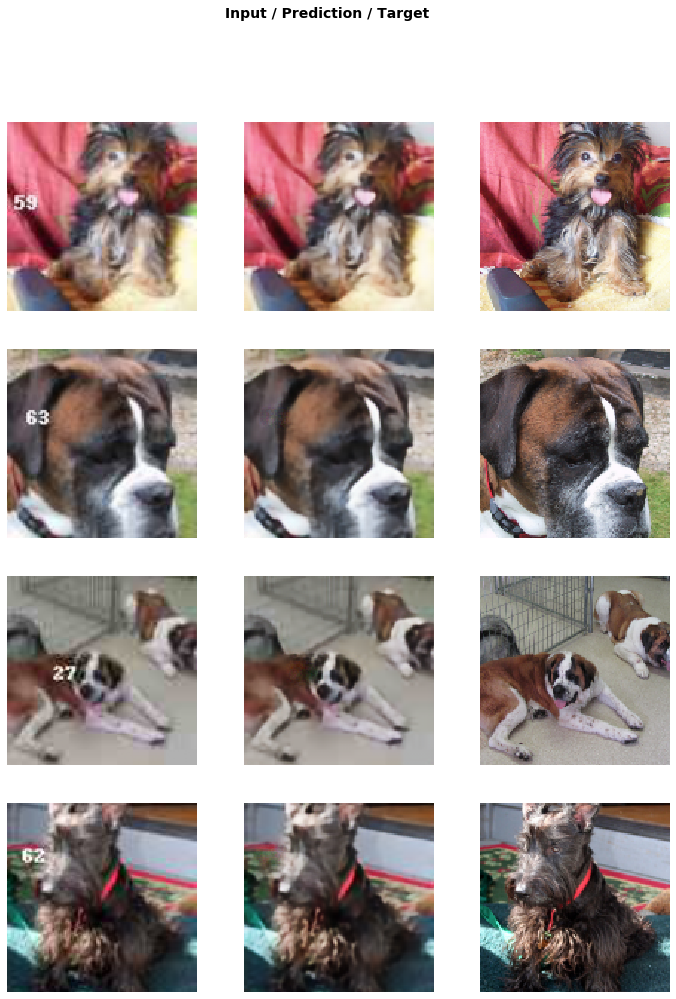

In [31]:
learn_gen.show_results(rows=4)

In [32]:
learn_gen.save("gen-pre2")

## Save generated images 

In [33]:
learn_gen.load("gen-pre2");

In [16]:
name_gen = "image_gen"
path_gen = path/name_gen

In [17]:
path_gen.mkdir(exist_ok=True)

In [18]:
def save_preds(dl):
    i=0
    names = dl.dataset.items
    
    for b in dl:
        preds = learn_gen.pred_batch(batch=b, reconstruct=True)
        for o in preds:
            o.save(path_gen/names[i].name)
            i += 1

In [40]:
save_preds(data_gen.fix_dl)

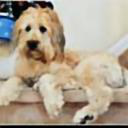

In [41]:
PIL.Image.open(path_gen.ls()[0])

## Train critic 

In [20]:
learn_gen=None
gc.collect()

20

In [21]:
def get_crit_data(classes, bs, size):
    src = ImageList.from_folder(path, include=classes).split_by_rand_pct(0.1, seed=42)
    ll = src.label_from_folder(classes=classes)
    data = (ll.transform(get_transforms(max_zoom=2.), size=size)
           .databunch(bs=bs).normalize(imagenet_stats))
    data.c = 3
    return data

In [22]:
data_crit = get_crit_data([name_gen, "images"], bs=bs, size=size)

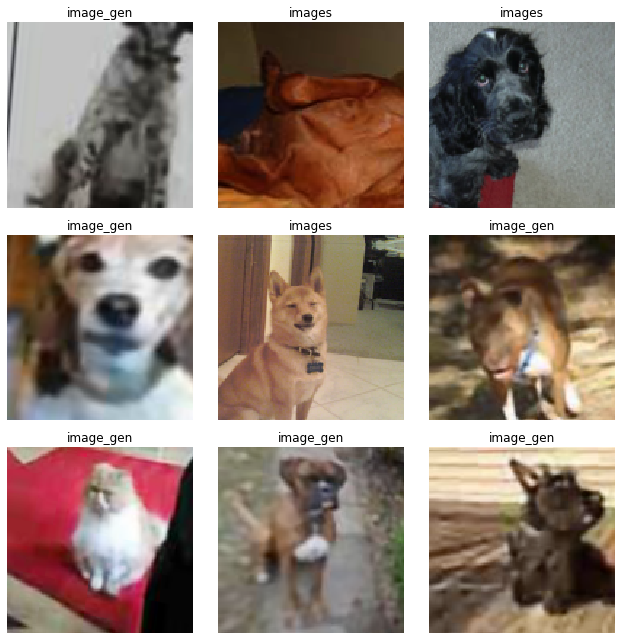

In [23]:
data_crit.show_batch(rows=3, ds_type=DatasetType.Train, imgsize=3)

In [24]:
loss_critic = AdaptiveLoss(nn.BCEWithLogitsLoss())

In [25]:
def create_critic_learner(data, metrics):
    return Learner(data, gan_critic(), metrics=metrics, loss_func=loss_critic, wd=wd)

In [26]:
learn_critic = create_critic_learner(data_crit, accuracy_thresh_expand)

In [56]:
learn_critic.fit_one_cycle(6, 1e-3)

epoch,train_loss,valid_loss,accuracy_thresh_expand,time
0,0.600909,0.583541,0.682678,04:15
1,0.232360,0.304769,0.885698,04:16
2,0.094379,0.171494,0.926667,04:16
3,0.062008,0.084268,0.971083,04:16
4,0.035433,0.064207,0.980684,04:17
5,0.031233,0.060190,0.982564,04:16


In [57]:
learn_critic.save("critic-pre2")

## GAN 

In [28]:
learn_crit = None
learn_gen = None
gc.collect()

20

In [29]:
data_crit = get_crit_data(["crappy", "images"], bs=bs, size=size)

In [30]:
learn_crit = create_critic_learner(data_crit, metrics=None).load('critic-pre2')

In [31]:
learn_gen = create_gen_learner().load("gen-pre2")

In [32]:
switcher = partial(AdaptiveGANSwitcher, critic_thresh=0.65)
learn = GANLearner.from_learners(
    learn_gen, learn_crit,
    weights_gen=(1.,50.),
    show_img=False,
    switcher=switcher,
    opt_func=partial(optim.Adam, betas=(0.,0.99)),
    wd=wd)
learn.callback_fns.append(partial(GANDiscriminativeLR, mult_lr=5.))

In [33]:
lr = 1e-4

In [31]:
learn.fit(40, lr)

In [32]:
learn.save('gan-1c')

In [34]:
learn.load('gan-1c');

In [35]:
learn.data=get_data(4,192)

In [36]:
learn.fit(10, lr/2)

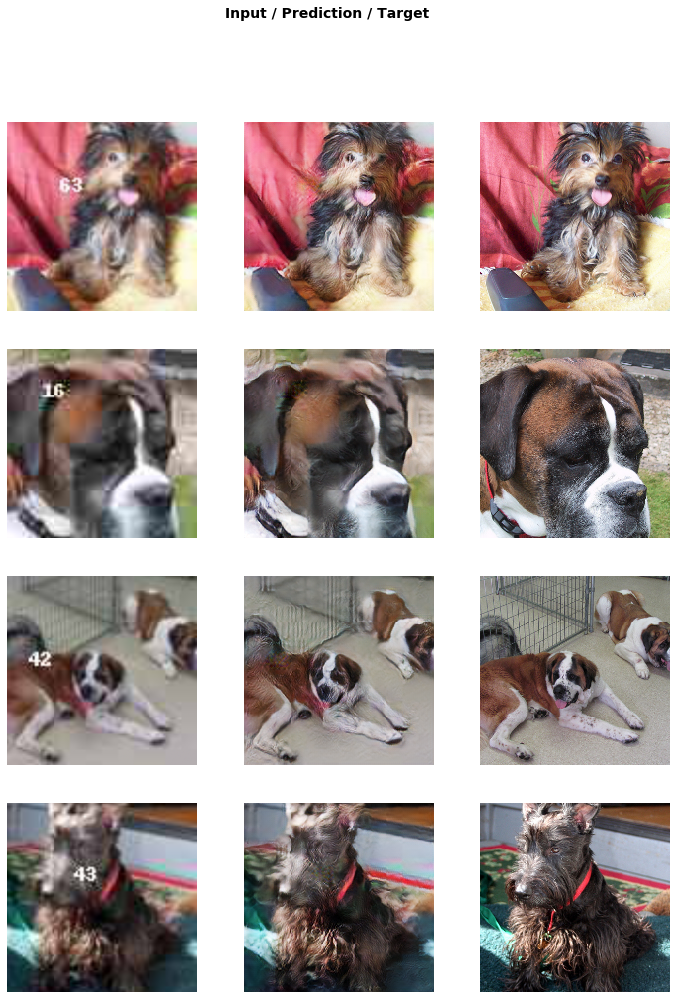

In [37]:
learn.show_results(rows=16)